Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [1]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()): #type: ignore
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = False #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive #type: ignore
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [2]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [3]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [4]:
from pprint import pprint
import dataclasses
pprint(dataclasses.asdict(vehicle_provider.next()))

{'in_platoon': False,
 'vulnerabilities': ({'prob': 0.5841726064682007,
                      'severity': 2,
                      'state': <CompromiseState.NOT_COMPROMISED: 1>},)}


### Game config

In [5]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=10 #@param {type:"integer"}
    ,
    cycle_enabled=False #@param {type:"boolean"}
    ,
    cycle_every=5 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=3 #@param {type:"integer"}
)

### Attacker agent config

In [6]:
from agents import AttackerAgent, PassiveAgent, BasicAttackerAgent
from game import State
from vehicles import CompromiseState

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  def get_attacker_utility(self:AttackerAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members if any([True if vuln.state != CompromiseState.NOT_COMPROMISED else False for vuln in v.vulnerabilities])]
    return len(comp)

  attacker = BasicAttackerAgent(
    attack_limit=1 #@param {type:"integer"}
    ,
    attack_interval=5 #@param {type:"integer"},
    ,
    utility_func=get_attacker_utility
  )
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [7]:
from agents import WolpertingerDefenderAgent, RandomDefenderAgent
from models import StateShapeData
from vehicles import Vehicle, Vulnerability

def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]

    ## return 1 if platoon size is 4
    # return 1 if len(members) == 4 else 0

    ## return the severity of the vulns in the platoon
    # return sum([sum([vuln.severity for vuln in vehicle.vulnerabilities]) for vehicle in members])

    ## return how many members are in the platoon
    # if len(members) == 5:
    #     return 10.0
    # else:
    #     return 0.0

    ## return platoon size if not compromised
    comp = [1 for v in members for vuln in v.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED]
    if len(comp) > 0: return 0
    return len(members)

load_checkpoint = False #@param {type:"boolean"}
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=100 #@param {type: "integer"}
    ,
    utility_func=get_defender_utility
    ,
    ou_theta = 0.0 #@param {type: "number"}
    ,
    ou_mu = 0.0 #@param {type: "number"}
    ,
    ou_sigma = 3 #@param {type: "number"}
    ,
    epsilon_decay_time=50000 #@param {type: "integer"}
)

random_defender = RandomDefenderAgent()
random_defender.get_utility = get_defender_utility.__get__(random_defender, get_defender_utility)  # type: ignore


if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Baseline evaluation

untrained defender


c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


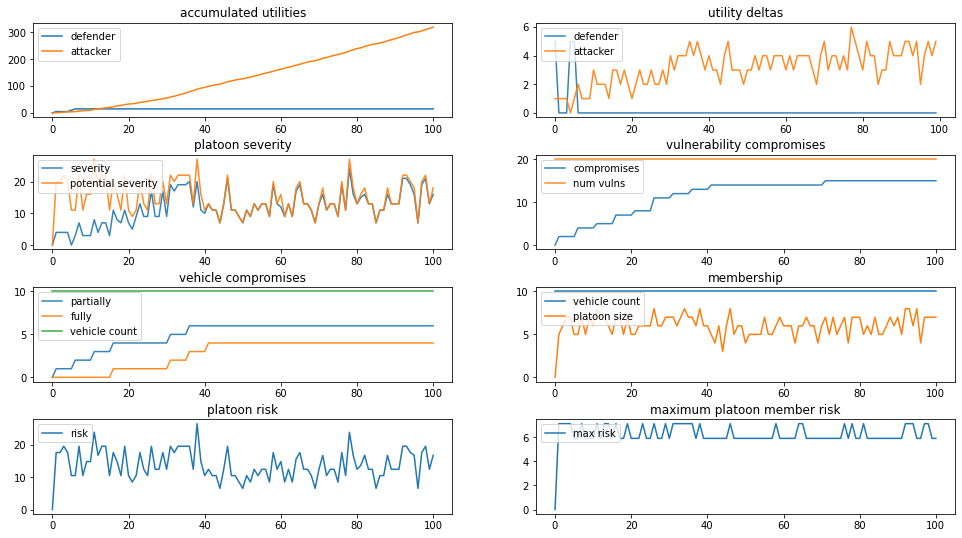

In [8]:
from agents import RandomDefenderAgent
from evaluation import get_episode_metrics

print("untrained defender")
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

random defender


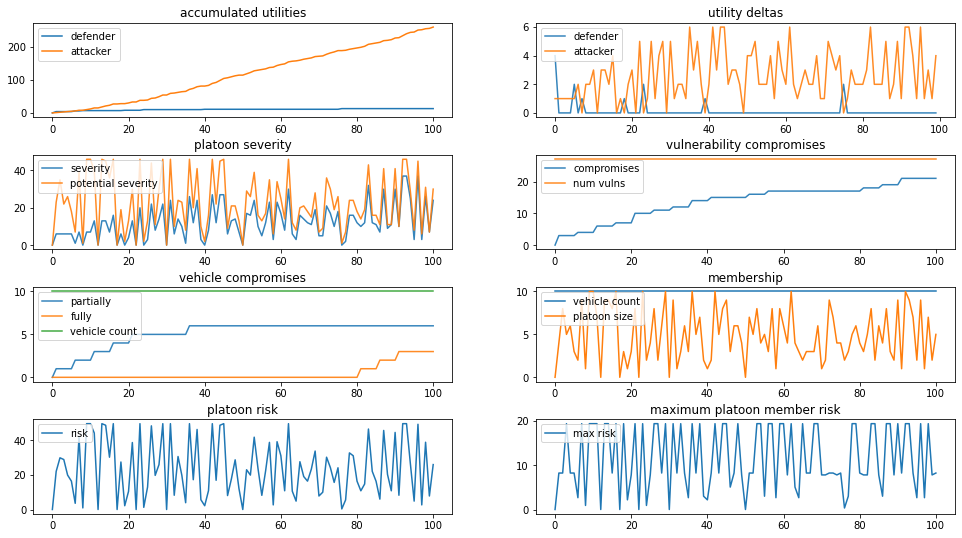

In [9]:
print("random defender")
get_episode_metrics(
    defender_agent=random_defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Replay memory config

In [10]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=100000 #@param {type:"integer"}
)

### Training metrics tracker config

In [11]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Trainer config

In [12]:
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=50 #@param {type:"integer"}
    ,
    train_steps=25 #@param {type:"integer"}
    ,
    exploration_per_step=5 #@param {type:"integer"}
    ,
    warmup_replay=2000 #@param {type:"integer"}
    ,
    max_steps_per_episode=5 #@param {type:"integer"}
    ,
    attacker_headstart=3 #@param {type:"integer"}
    ,
    update_policy_interval=1 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
))

### Generate warmup samples from random actions

In [13]:
trainer.warmup()

Warming up...


  0%|          | 0/2000 [00:00<?, ?it/s]

Warmup complete~!


In [14]:
# arbitrary number, but we need to be sure there are enough transitions that have rewards
# lost a lot of time debugging because of this
reward_expectation=50 #@param {type:"integer"}
reward_expectation_steps = 1000 #@param {type:"integer"}
reward_sum = sum([e.reward for e in memory][:reward_expectation_steps]) 
print(reward_sum)
assert reward_sum > reward_expectation

tensor([1304.])


(array([1301.,  135.,  130.,  117.,   76.,   58.,   65.,   50.,   36.,
          32.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

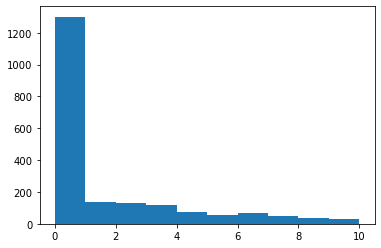

In [15]:
import matplotlib.pyplot as plt
rewards = [float(x.reward) for x in memory]
plt.hist(rewards)

In [16]:
# ensure that there are equal zero and non-zero rewards
zero = [x for x in memory if x.reward == 0]
notzero = [x for x in memory if x.reward != 0]
zeroToAdd = len(notzero) - len(zero)
for i in range(zeroToAdd):
    memory.push(zero[i % len(zero)])
for i in range(-zeroToAdd):
    memory.push(notzero[i % len(notzero)])

(array([1301.,  252.,  237.,  220.,  140.,  110.,  122.,   94.,   68.,
          58.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

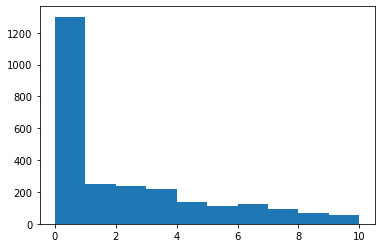

In [17]:
rewards = [float(x.reward) for x in memory]
plt.hist(rewards)

(array([147.,  82., 182., 223., 180., 113.,  43.,  17.,   8.,   5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

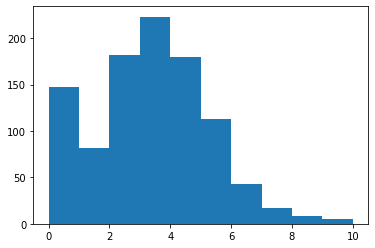

In [18]:
check_vulns = 1000
comps = [
    x.state.vulnerabilities[:,:,:,3].sum().item()
    for x in memory.sample(check_vulns)
]
plt.hist(comps)

### Perform training

In [19]:
# todo: ensure agent is actually getting reported estimated policy loss
# agent seems to be getting no rewards when evaluated, so why is expected policy loss reporting it should be getting rewards?
# todo: investigate adaptive learning rate, lower learning rate
trainer.train()

Warming up...


0it [00:00, ?it/s]

Warmup complete~!


  0%|          | 0/25 [00:00<?, ?it/s]

train step 00 

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


reward={max=06.0000, min=00.0000, mean=01.8000} optimizing loss=10.3380 diff={max=08.0700, min=00.0105, mean=02.0333} policy_loss=-16.8426 policy updated! 
train step 01 reward={max=08.0000, min=00.0000, mean=01.6000} optimizing loss=246.7861 diff={max=27.3682, min=01.9474, mean=14.1559} policy_loss=-0.2351 policy updated! 
train step 02 reward={max=00.0000, min=00.0000, mean=00.0000} optimizing loss=10.7345 diff={max=09.9226, min=00.0668, mean=02.2810} policy_loss=00.0026 policy updated! 
train step 03 reward={max=00.0000, min=00.0000, mean=00.0000} optimizing loss=09.8015 diff={max=10.3712, min=00.0059, mean=01.8144} policy_loss=02.3932 policy updated! 
train step 04 reward={max=03.0000, min=00.0000, mean=01.8000} optimizing loss=37.7734 diff={max=14.6248, min=00.0749, mean=04.9221} policy_loss=-0.4339 policy updated! 
train step 05 reward={max=03.0000, min=00.0000, mean=02.4000} optimizing loss=08.4955 diff={max=07.0230, min=00.0320, mean=02.0541} policy_loss=-0.8045 policy updated!

In [20]:
attempt_gpu_mem_flush = False #@param {type:"boolean"}
if attempt_gpu_mem_flush:
    import torch
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

### View training metrics

No stats to plot below loss threshold 5
No stats to plot below loss threshold 1


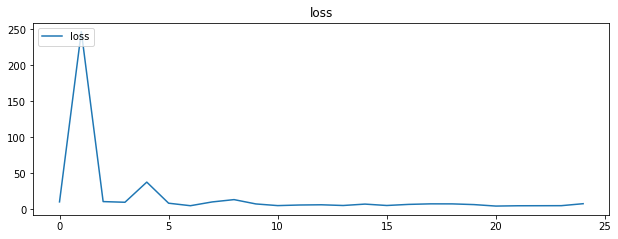

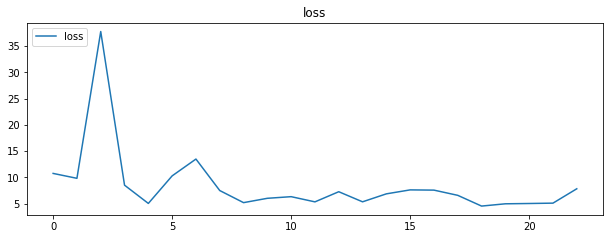

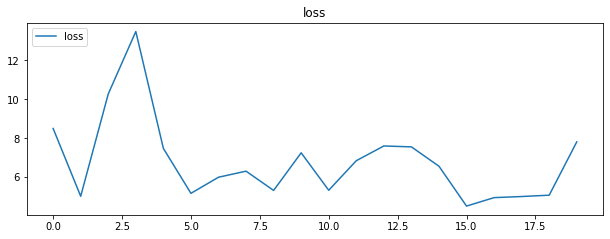

In [24]:
tracker.plot()
tracker.plot(loss_threshold=100)
tracker.plot(loss_threshold=20)
tracker.plot(loss_threshold=5)
tracker.plot(loss_threshold=1)

## Evaluation

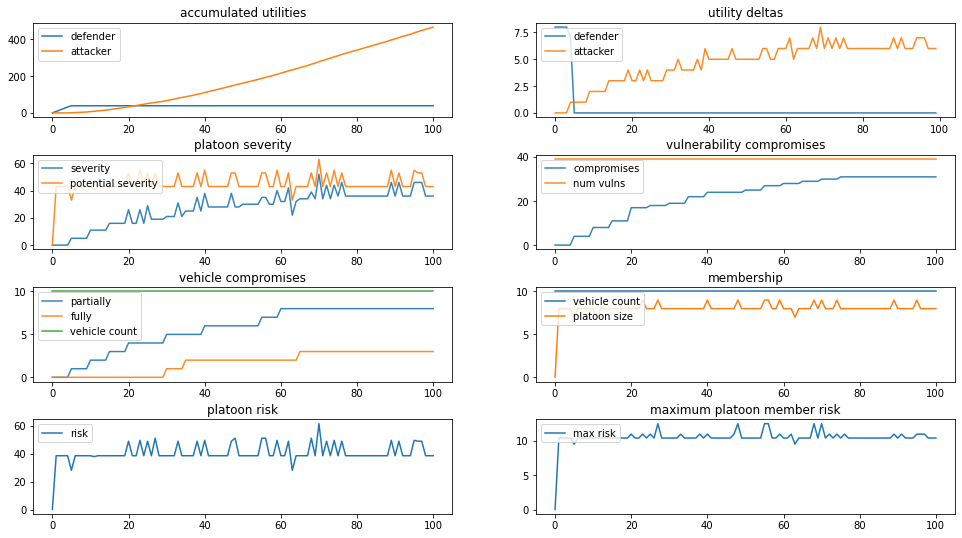

In [25]:
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

In [34]:
from memory import TransitionTensorBatch
from utils import get_device

batch = TransitionTensorBatch.cat(memory.sample(10)).to(get_device())

print("action", batch.action.members)
print("reward", batch.reward)
q_values = defender.critic(batch.state, batch.action)
print("reward prediction", q_values)
print("pred reward err", q_values - batch.reward)


action tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 0., 0., 1., 1., 0., 1.]])
reward tensor([1., 1., 7., 0., 1., 4., 7., 0., 5., 0.])
reward prediction tensor([1.5254, 1.5303, 1.4631, 1.4312, 1.8162, 1.5335, 1.8141, 1.4706, 1.5496,
        1.5839], grad_fn=<ReshapeAliasBackward0>)
pred reward err tensor([ 0.5254,  0.5303, -5.5369,  1.4312,  0.8162, -2.4665, -5.1859,  1.4706,
        -3.4504,  1.5839], grad_fn=<SubBackward0>)


In [35]:
proto_actions = defender.actor(batch.state)
# print("proto action", proto_actions)
proto_actions = proto_actions.as_binary()
print("collapsed action", proto_actions)
q_values = defender.critic(batch.state, proto_actions)
print("predicted reward", q_values)

collapsed action DefenderActionTensorBatch(members=tensor([[1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 0., 1., 1.]]))
predicted reward tensor([1.5410, 1.5366, 1.4630, 1.4228, 1.8239, 1.5359, 1.8152, 1.4770, 1.5519,
        1.5869], grad_fn=<ReshapeAliasBackward0>)


In [ ]:
del batch

## Manually checkpoint model

In [ ]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)